# Practica 2: Modelos de Clasificacion de Credito - COMPLETA

**Objetivo:** Implementar y optimizar modelos para clasificacion binaria.

**Contexto:** Coste de FP (dar credito no devuelto) = 4x coste FN (no dar credito devuelto).

In [139]:
import pandas as pd     # Manipulación y análisis de datos
import numpy as np      # Cálculos numéricos  
import matplotlib.pyplot as plt # Visualización de datos
import seaborn as sns   # Visualización de datos avanzada

# Importación de librerías de Scikit-Learn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
#trein_test_split divide el conjunto de datos en conjuntos de entrenamiento y prueba
#GridSearchCV realiza una búsqueda para encontrar los mejores hiperparámetros
#StratifiedKFold crea pliegues estratificados para validación cruzada

from sklearn.preprocessing import StandardScaler, OneHotEncoder
#StandardScaler Normaliza variables numéricas (media 0, varianza 1)
#OneHotEncoder Convierte variables categóricas en variables binarias.

from sklearn.compose import ColumnTransformer   
#Permite aplicar varios transformadores a distintas columnas del dataset.

from sklearn.pipeline import Pipeline
#Conecta pasos secuenciales: preprocesamiento → modelo.

from sklearn.linear_model import LogisticRegression
#Regresión logística para clasificación binaria y multiclase

from sklearn.tree import DecisionTreeClassifier
#Árboles de decisión para clasificación y regresión

from sklearn.neighbors import KNeighborsClassifier
#Clasificador basado en la proximidad de los vecinos más cercanos

from sklearn.naive_bayes import GaussianNB
#Clasificador basado en el teorema de Bayes con suposiciones gaussianas

from sklearn.metrics import make_scorer
from sklearn.utils import resample

from sklearn.metrics import (confusion_matrix,
                             roc_auc_score, roc_curve, accuracy_score,
                            )
#Métricas para evaluar el rendimiento de modelos de clasificación
    #confusion_matrix Matriz de confusión
    #roc_auc_score Área bajo la curva ROC
    #roc_curve Curva ROC
    #accuracy_score Precisión del modelo



%matplotlib inline
# Configuración de estilos de visualización

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)

print('LIBRERIAS IMPORTADAS')

LIBRERIAS IMPORTADAS


## Apartado A: Analisis Exploratorio


DISTRIBUCION DE CLASES:
returned_credit
1    700
0    300
Name: count, dtype: int64

Proporcion:
returned_credit
1    0.7
0    0.3
Name: proportion, dtype: float64


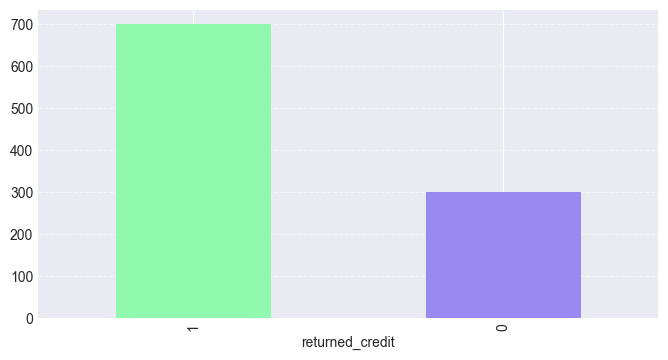

In [140]:
# Carga del dataset para el entendimiento de los modelos de clasificación
df = pd.read_csv('credit_practice_dataset.csv')


print('\nDISTRIBUCION DE CLASES:')
print(df['returned_credit'].value_counts())
print('\nProporcion:')
print(df['returned_credit'].value_counts(normalize=True))

plt.figure(figsize=(8,4))

# Gráfico de barras para la distribución de clases
ax = df['returned_credit'].value_counts().plot(kind='bar', color=["#91F9AD", "#9B89F2"])

# Cuadrícula solo en las líneas del eje Y (lo que se usa en un barplot vertical)
ax.yaxis.grid(True, linestyle='--', alpha=0.6)

plt.show()



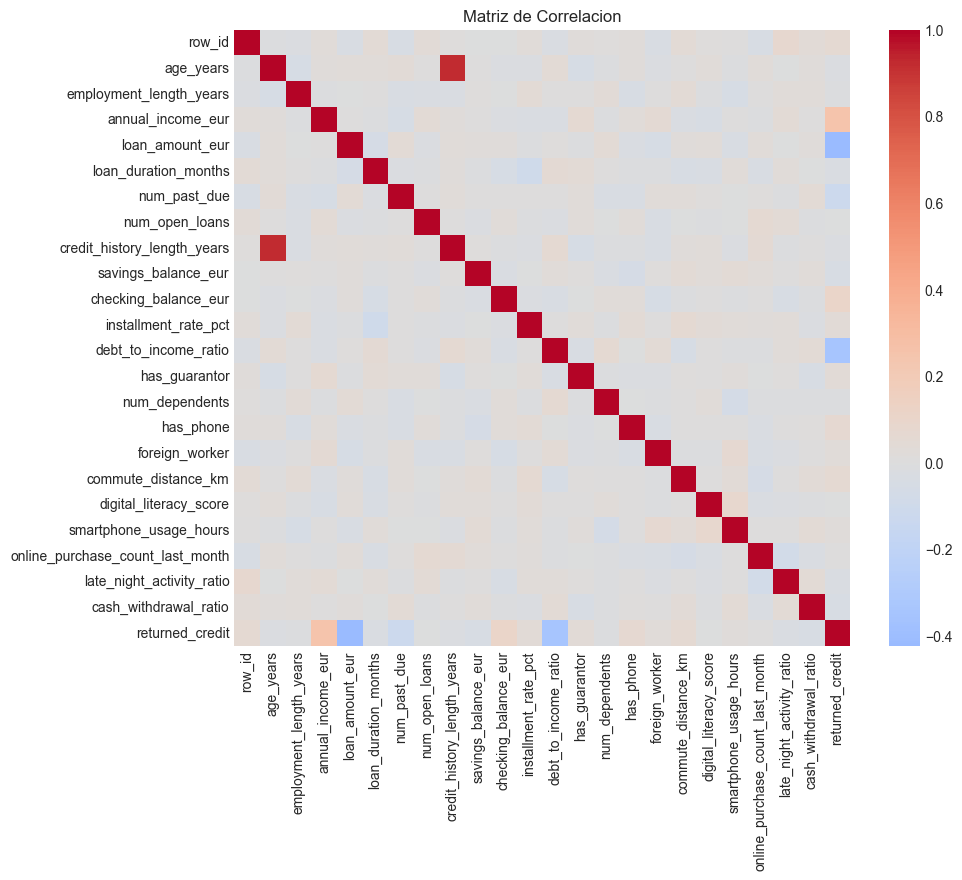

In [141]:
numeric_df = df.select_dtypes(include=[np.number])
# Selecciona solo las columnas numéricas del DataFrame

corr = numeric_df.corr()
# Calcula la matriz de correlación entre las variables numéricas

target_corr = corr['returned_credit'].sort_values(ascending=False)
# Obtiene las correlaciones de todas las variables con la variable objetivo 'returned_credit' y las ordena


# Visualización de la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', center=0, square=True, annot=False)
plt.title('Matriz de Correlacion')
plt.show()

## Apartado B: Preprocesamiento

In [142]:

# DIVISIÓN INICIAL DEL DATASET EN TRAIN/TEST ---
Y = df['returned_credit']
X = df.drop(columns=['row_id', 'returned_credit'])


# División 70% entrenamiento y 30% prueba eqiuitativa en porcentajes.
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42, stratify=Y
)

print('DIVISION TRAIN/TEST (Inicial):')
print(f'Train: {X_train.shape[0]}, Test: {X_test.shape[0]}')


# Identificar las variables numéricas
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()

# Calcular la media y la desviación típica (SOLO en el conjunto de entrenamiento)
mean_train = X_train[numeric_features].mean()
std_train = X_train[numeric_features].std()

# Definir el umbral (3.0 desviaciones típicas)
threshold = 3.0

# Calcular la Z-score para el conjunto de entrenamiento
z_scores = (X_train[numeric_features] - mean_train) / std_train

# Identificar filas a conservar (donde NINGUNA columna numérica es un outlier)
# Una fila se considera outlier si alguna de sus columnas numéricas supera el umbral
outlier_mask = np.abs(z_scores) > threshold
rows_to_keep = ~outlier_mask.any(axis=1)

# Filtrar X_train y y_train
X_train_temp = X_train[rows_to_keep]
y_train_temp = y_train[rows_to_keep]

print(f'\nOUTLIER REMOVAL (Umbral: {threshold} sigma):')
print(f'Filas eliminadas de Train: {X_train.shape[0] - X_train_temp.shape[0]}')

# Actualizar X_train y y_train con los datos filtrados 
X_train = X_train_temp
y_train = y_train_temp

print(f'Nuevo tamaño de X_train_filtered: {X_train.shape[0]}')
print(f'Nuevo tamaño de y_train_filtered: {y_train.shape[0]}')

numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Transformador Numérico (Solo Normalización)
numeric_transformer = StandardScaler()
# Transformador Categórico (Codificación Numérica)
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first') 

# Combinación de Transformadores
preprocessor = ColumnTransformer(
    transformers=[
        # Se normalizan las variables numéricas (ya filtradas)
        ('num', numeric_transformer, numeric_features), 
        # Se codifican las variables categóricas
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

print('\nPreprocesador CREADO y LISTO PARA USAR.')



DIVISION TRAIN/TEST (Inicial):
Train: 700, Test: 300

OUTLIER REMOVAL (Umbral: 3.0 sigma):
Filas eliminadas de Train: 229
Nuevo tamaño de X_train_filtered: 471
Nuevo tamaño de y_train_filtered: 471

Preprocesador CREADO y LISTO PARA USAR.


El objetivo de este preprocesamiento es limpiar, estandarizar y transformar los datos para asegurar que el modelo de Machine Learning pueda entrenarse de manera eficiente y justa.

El conjunto de datos original se dividió en conjuntos de entrenamiento (70%) y prueba (30%). Medainte train_test_split(..., test_size=0.3, stratify=Y).
Con el fin de evitar el sobreajuste el conjunto de prueba (X_test) garantiza una evaluación imparcial del modelo con datos que nunca ha visto, ademas se garantiza la equidad de Clases, que que el parámetro stratify=Y asegura que la proporción de créditos devueltos sea idéntica en los conjuntos de entrenamiento y prueba.

Se identificaron y eliminaron filas donde las variables numéricas presentaban valores extremos o outliers, gracias a la Z-score (z = (x - \mu) / \sigma) para cada valor numérico en el conjunto de entrenamiento, se eliminaron las filas de X_train y y_train donde el valor se encontraba a más de 3 desviaciones típicas de la media, ya que 2 eliminaba demasiados datos y 4 no eliminaba casi ninguno. Esto mejora la Robustez del Modelo y evitar los valores extremos distorsionen la media y la desviación típica, asegurando un entrenamiento más estable.

Se definió un ColumnTransformer para aplicar las transformaciones necesarias a cada tipo de dato de forma independiente.

Para variables Numéricas, se utiliza StandardScaler(), para asegurar que todas las variables numéricas contribuyan por igual al modelo, independientemente de su escala original, lo que acelera la convergencia de los algoritmos. Y para variables Categóricas, se utiliza la codificación Numérica con OneHotEncoder(drop='first'), la cual transformar el texto a un formato numérico que los algoritmos de Machine Learning pueden procesar, evitando al mismo tiempo asumir una relación de orden incorrecta.

## Apartado C: Entrenamiento de Modelos Iniciales

**Modelos:** Logistic Regression (C=0.001), Decision Tree, KNN (k=1), Naive Bayes

In [143]:
print('ENTRENAMIENTO DE MODELOS INICIALES')

pipe_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(C=0.001, max_iter=1000, random_state=42))
])
pipe_lr.fit(X_train, y_train)
print('- Logistic Regression (C=0.001): OK')

pipe_dt = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])
pipe_dt.fit(X_train, y_train)
print('- Decision Tree (sin limite profundidad): OK')

pipe_knn = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=1))
])
pipe_knn.fit(X_train, y_train)
print('- KNN (k=1): OK')

pipe_nb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])
pipe_nb.fit(X_train, y_train)
print('- Naive Bayes: OK')

models = {
    'Logistic Regression': pipe_lr,
    'Decision Tree': pipe_dt,
    'KNN': pipe_knn,
    'Naive Bayes': pipe_nb
}

ENTRENAMIENTO DE MODELOS INICIALES
- Logistic Regression (C=0.001): OK
- Decision Tree (sin limite profundidad): OK
- KNN (k=1): OK
- Naive Bayes: OK



CALCULANDO MÉTRICAS:
- Logistic Regression: Accuracy Train=0.7070, Test=0.7000
- Decision Tree: Accuracy Train=1.0000, Test=0.7600
- KNN: Accuracy Train=1.0000, Test=0.7067
- Naive Bayes: Accuracy Train=0.7962, Test=0.7433

 ---TABLA DE RESULTADOS ---
             Modelo  Accuracy (Test)
      Decision Tree           0.7600
        Naive Bayes           0.7433
                KNN           0.7067
Logistic Regression           0.7000


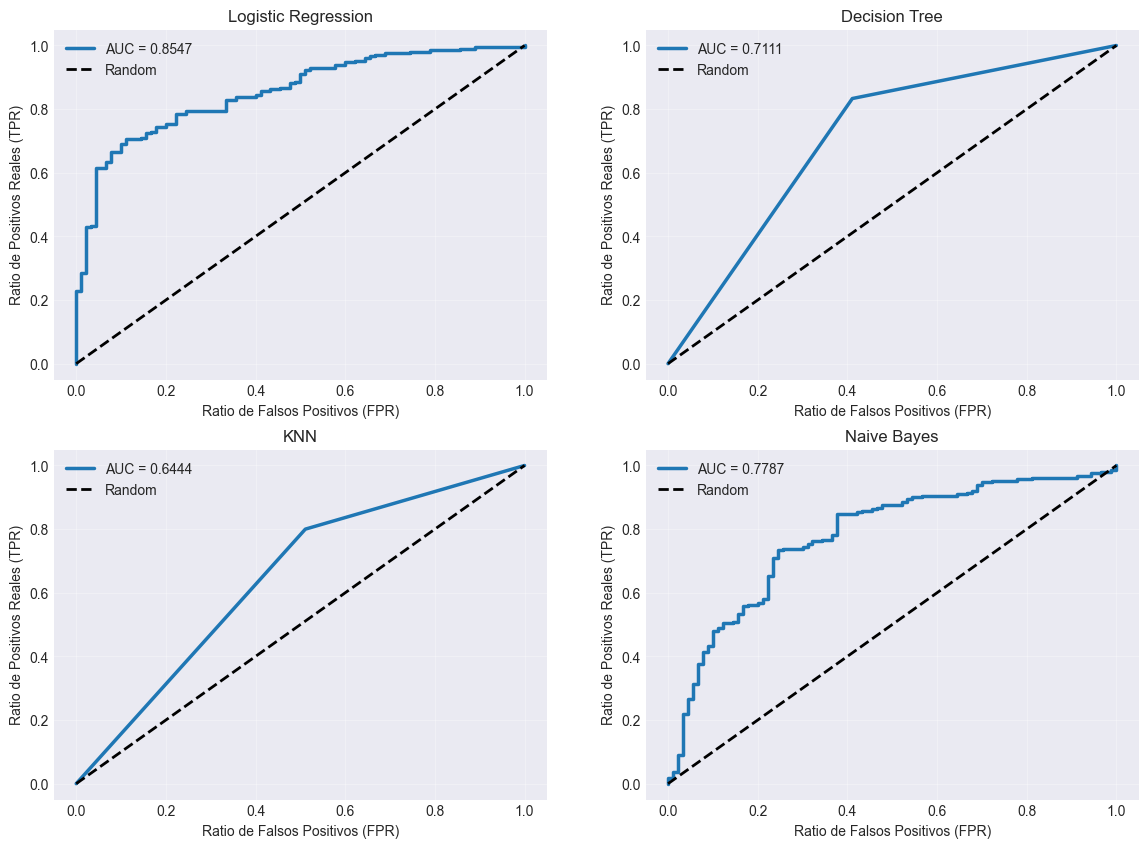

In [144]:
results = []  # Lista para almacenar los resultados de cada modelo
print('\nCALCULANDO MÉTRICAS:')

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

# 2. Iterar sobre los modelos para calcular Accuracy
for idx, (name, model) in enumerate(models.items()):
    
    # Predecir en ambos conjuntos
    # Nota: El preprocesador ya aplica la lógica de filtrado/transformación
    # X_train debe usarse si se filtró previamente.
    # Asumiendo que X_train es el conjunto limpio:
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calcular Accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    # Almacenar resultados
    results.append({
        'Modelo': name,
        'Accuracy (Train)': train_acc,
        'Accuracy (Test)': test_acc
    })
    print(f'- {name}: Accuracy Train={train_acc:.4f}, Test={test_acc:.4f}')

    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    
    # Plot de la curva ROC
    axes[idx].plot(fpr, tpr, lw=2.5, label=f'AUC = {auc:.4f}')
    axes[idx].plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
    axes[idx].set_xlabel('Ratio de Falsos Positivos (FPR)')
    axes[idx].set_ylabel('Ratio de Positivos Reales (TPR)')
    axes[idx].set_title(name)
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)


# 3. Generar la tabla comparativa
df_results = pd.DataFrame(results)

# Mantener solo la columna de Accuracy en Test (y la columna Modelo)
df_results = df_results[['Modelo', 'Accuracy (Test)']]
print('\n ---TABLA DE RESULTADOS ---')
# Usamos to_string() para mostrar la tabla sin dependencias externas
print(df_results.sort_values(by='Accuracy (Test)', ascending=False).to_string(index=False, float_format="%.4f"))

## Apartado D: Evaluacion Inicial Optimizada

En este apartado se optizaran aquellos modelos posibles mediante 10-fold cross-validation para saber si el modelo optimizado tiene mejor rendimiento.

In [145]:
#Definir los parámetros para cada modelo
parametros_para_cada_modelo = {
    'Logistic Regression': {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Ajustar C (fuerza de regularización)
    },
    'Decision Tree': {
        'classifier__max_depth': [None, 5, 10, 15, 20, 30],       # Ajustar profundidad máxima del árbol
    },
    'KNN': {
        'classifier__n_neighbors': [1, 3, 5, 7, 9, 11, 15],       # Ajustar k (número de vecinos)
    }
}
# Definir el objeto de Validación Cruzada (K=10) 
# usando StratifiedKFold para mantener la proporción de clases en cada fold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    #n_splits=10: Número de pliegues (folds) para la validación cruzada.
    #shuffle=True: Mezcla los datos antes de dividirlos en pliegues.
    #random_state=42: Fija la semilla para reproducibilidad.

# Preparar la estructura para guardar resultados y modelos optimizados
optimized_models = models.copy() # Inicializamos con los modelos base
optimization_results = []


In [146]:
for name, pipe in models.items():
    if name in parametros_para_cada_modelo:
        print(f"\n--- Optimizando {name} ---")

        # Inicializar GridSearchCV para realizar el mejoramiento de hiperparámetros
        grid_search = GridSearchCV(
            estimator=pipe,
            param_grid=parametros_para_cada_modelo[name],
            scoring='accuracy',  # Métrica a optimizar
            cv=cv,               # 10-fold CV
            n_jobs=-1,           # Usar todos los núcleos de CPU
            verbose=1            # Mostrar progreso
        )

        # Entrenar el Grid Search (esto hace la validación cruzada)
        grid_search.fit(X_train, y_train)

        # Obtener el mejor modelo y sus métricas
        best_estimator = grid_search.best_estimator_
        best_param = grid_search.best_params_
        best_cv_accuracy = grid_search.best_score_
        
        # Actualizar el modelo optimizado
        optimized_models[name] = best_estimator
        
        # Calcular Accuracy en el conjunto de prueba con el modelo optimizado
        test_acc_optimized = accuracy_score(y_test, best_estimator.predict(X_test))

        # Almacenar resultados de la optimización
        optimization_results.append({
            'Modelo': name,
            'Parámetro Optimizado': best_param,
            'Media de precision durante la validación cruzada': best_cv_accuracy,
            'Accuracy Test (Optimizado)': test_acc_optimized
        })
        
        print(f"Mejor parámetro: {best_param}")
        print(f"Media de precision durante la validación cruzada (Optimizado): {best_cv_accuracy:.4f}")
        print(f"Accuracy Test (Optimizado): {test_acc_optimized:.4f}")

    else:
        # El modelo Naive Bayes no tiene hiperparámetros sencillos de optimizar en este contexto
        print(f"\n--- {name} (Sin optimización de hiperparámetros) ---")


# Crear DataFrame con los resultados de la optimización
df_results_optimized = pd.DataFrame(optimization_results)



--- Optimizando Logistic Regression ---
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Mejor parámetro: {'classifier__C': 0.1}
Media de precision durante la validación cruzada (Optimizado): 0.8451
Accuracy Test (Optimizado): 0.7900

--- Optimizando Decision Tree ---
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Mejor parámetro: {'classifier__max_depth': 10}
Media de precision durante la validación cruzada (Optimizado): 0.7473
Accuracy Test (Optimizado): 0.7633

--- Optimizando KNN ---
Fitting 10 folds for each of 7 candidates, totalling 70 fits
Mejor parámetro: {'classifier__n_neighbors': 5}
Media de precision durante la validación cruzada (Optimizado): 0.7940
Accuracy Test (Optimizado): 0.7300

--- Naive Bayes (Sin optimización de hiperparámetros) ---


In [ ]:

# Renombrar la columna de Accuracy de test inicial para la fusión
df_results = df_results.rename(
    columns={'Accuracy (Test)': 'Accuracy Test (Inicial)'}
)

modelos_a_incluir = df_results_optimized['Modelo'].unique()
df_results = df_results[df_results['Modelo'].isin(modelos_a_incluir)]

# Seleccionar columnas clave de la tabla inicial
df_initial_merge = df_results[['Modelo', 'Accuracy Test (Inicial)']]

# 3.2. Fusionar las dos tablas
df_comparison = pd.merge(
    df_results_optimized,
    df_initial_merge,
    on='Modelo',
    how='left'
)

#Seleccionar y ordenar columnas clave
df_comparison = df_comparison[[
    'Modelo',
    'Accuracy Test (Inicial)',
    'Accuracy Test (Optimizado)'
]].sort_values(by='Accuracy Test (Optimizado)', ascending=False)

# Mostrar la tabla comparativa final
print('TABLA COMPARATIVA:')
print(df_comparison.to_string(index=False, float_format="%.4f"))

TABLA COMPARATIVA: RENDIMIENTO INICIAL VS. OPTIMIZADO (Solo Modelos Ajustados)
             Modelo  Accuracy Test (Inicial)  Accuracy Test (Optimizado)
Logistic Regression                   0.7000                      0.7900
      Decision Tree                   0.7600                      0.7633
                KNN                   0.7067                      0.7300


La optimización de hiperparámetros transformó drásticamente el rendimiento de tus modelos: 

La Regresión Logística fue el mayor éxito, mejorando de 0.7000 a 0.7900 y convirtiéndose en el mejor modelo final; 

El Árbol de Decisión ya tenía un alto rendimiento inicial (0.7600), logrando solo una mejora marginal (a 0.7633) al limitar su profundidad; 

El KNN tuvo una mejora moderada de 0.7067 a 0.7300 al optimizar el número de vecinos ($k$), lo que confirma que el ajuste fino es esencial para liberar el potencial de un modelo.


--- GRAFICAS ROC/AUC DE MODELOS OPTIMIZADOS ---
- Logistic Regression: AUC=0.8750
- Decision Tree: AUC=0.7288
- KNN: AUC=0.7523
- Naive Bayes: AUC=0.7787


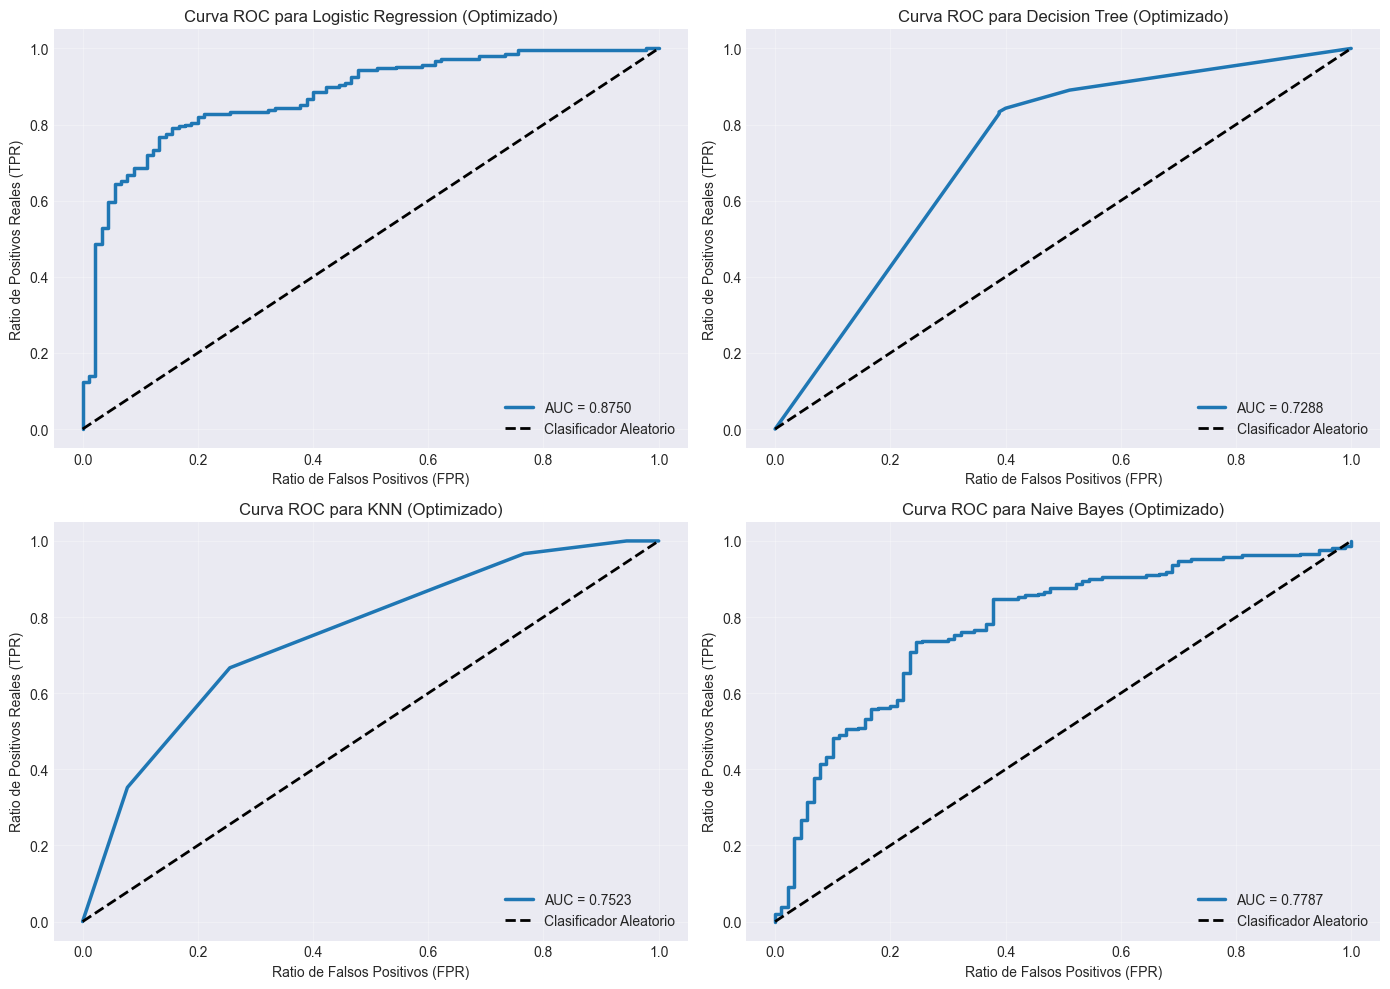

In [153]:
print('\n--- GRAFICAS ROC/AUC DE MODELOS OPTIMIZADOS ---')  

# Definir la figura y los ejes para las 4 gráficas (3 optimizados + Naive Bayes)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

# 1. Iterar sobre los modelos optimizados para calcular y graficar ROC/AUC
for idx, (name, model) in enumerate(optimized_models.items()):
    
    # 2. Predecir probabilidades para el conjunto de prueba
    # Usamos predict_proba para la curva ROC
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # 3. Calcular la curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    
    # 4. Calcular el AUC
    auc = roc_auc_score(y_test, y_prob)
    
    # Almacenar el AUC en los resultados (opcional, pero útil para la tabla)
    # Si estás usando el código anterior, puedes actualizar df_optimized con esta métrica

    # 5. Plot de la curva ROC
    axes[idx].plot(fpr, tpr, lw=2.5, label=f'AUC = {auc:.4f}')
    axes[idx].plot([0, 1], [0, 1], 'k--', lw=2, label='Clasificador Aleatorio')
    axes[idx].set_xlabel('Ratio de Falsos Positivos (FPR)')
    axes[idx].set_ylabel('Ratio de Positivos Reales (TPR)')
    axes[idx].set_title(f'Curva ROC para {name} (Optimizado)')
    axes[idx].legend(loc="lower right")
    axes[idx].grid(alpha=0.3)
    
    print(f"- {name}: AUC={auc:.4f}")

plt.tight_layout()
plt.show()

# --- Fin del código de gráficas ---


CALCULANDO MÉTRICAS:
- Logistic Regression: Accuracy Train=0.7070, Test=0.7000
- Decision Tree: Accuracy Train=1.0000, Test=0.7600
- KNN: Accuracy Train=1.0000, Test=0.7067
- Naive Bayes: Accuracy Train=0.7962, Test=0.7433

 ---TABLA DE RESULTADOS ---
             Modelo  Accuracy (Test)
      Decision Tree           0.7600
        Naive Bayes           0.7433
                KNN           0.7067
Logistic Regression           0.7000


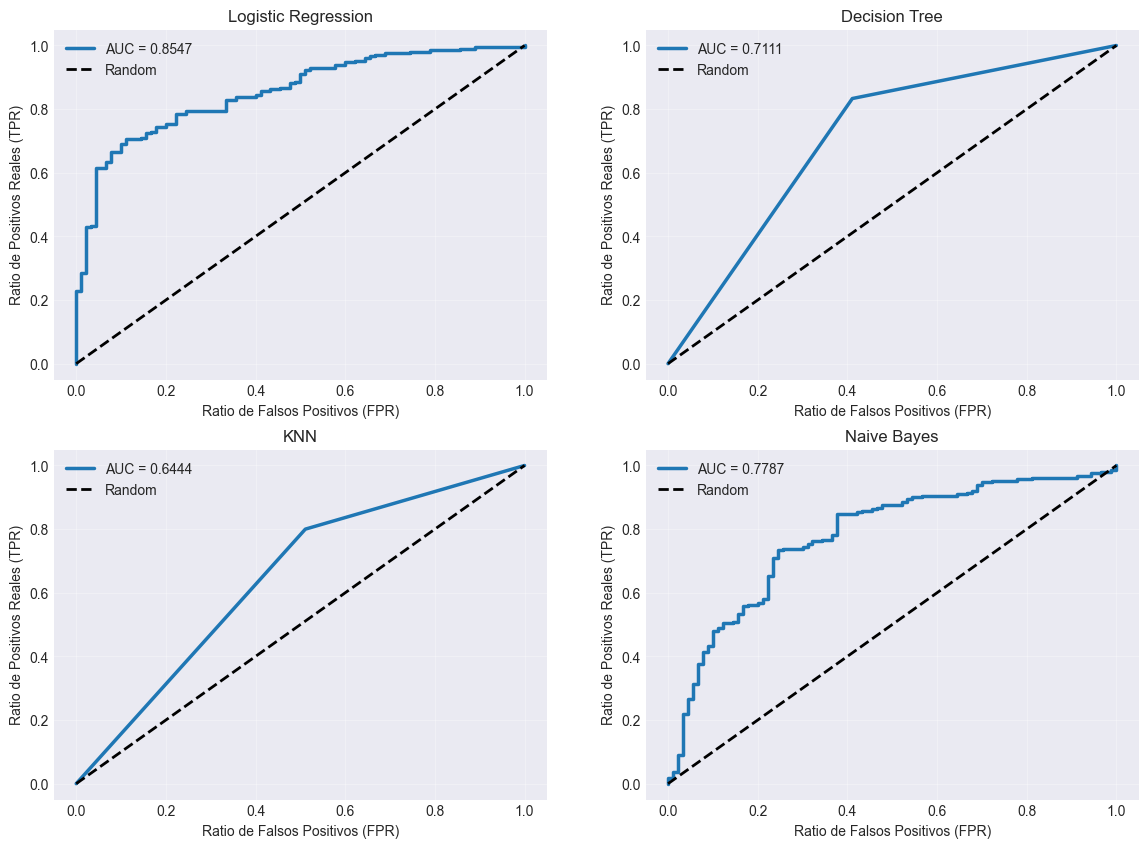

In [149]:
results = []  # Lista para almacenar los resultados de cada modelo
print('\nCALCULANDO MÉTRICAS:')

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

# 2. Iterar sobre los modelos para calcular Accuracy
for idx, (name, model) in enumerate(models.items()):
    
    # Predecir en ambos conjuntos
    # Nota: El preprocesador ya aplica la lógica de filtrado/transformación
    # X_train debe usarse si se filtró previamente.
    # Asumiendo que X_train es el conjunto limpio:
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calcular Accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    # Almacenar resultados
    results.append({
        'Modelo': name,
        'Accuracy (Train)': train_acc,
        'Accuracy (Test)': test_acc
    })
    print(f'- {name}: Accuracy Train={train_acc:.4f}, Test={test_acc:.4f}')

    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    
    # Plot de la curva ROC
    axes[idx].plot(fpr, tpr, lw=2.5, label=f'AUC = {auc:.4f}')
    axes[idx].plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
    axes[idx].set_xlabel('Ratio de Falsos Positivos (FPR)')
    axes[idx].set_ylabel('Ratio de Positivos Reales (TPR)')
    axes[idx].set_title(name)
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)


# 3. Generar la tabla comparativa
df_results = pd.DataFrame(results)

# Mantener solo la columna de Accuracy en Test (y la columna Modelo)
df_results = df_results[['Modelo', 'Accuracy (Test)']]
print('\n ---TABLA DE RESULTADOS ---')
# Usamos to_string() para mostrar la tabla sin dependencias externas
print(df_results.sort_values(by='Accuracy (Test)', ascending=False).to_string(index=False, float_format="%.4f"))

## APARTADO E: Optimización basada en Coste de Negocio

Costes de los modelos actuales (Umbral 0.5):
 - Logistic Regression: 360
 - Decision Tree: 183
 - KNN: 226
 - Naive Bayes: 179

Iniciando optimización (GridSearch + Threshold Tuning)...

TABLA COMPARATIVA DE COSTES:
             Modelo  Coste Inicial (Th=0.5)  Coste Final (Th Optimo)  Umbral Óptimo  Mejora Total
Logistic Regression                     360                      123            0.7           237
      Decision Tree                     183                      152            0.6            31
                KNN                     226                      176            0.7            50
        Naive Bayes                     179                      153            0.8            26


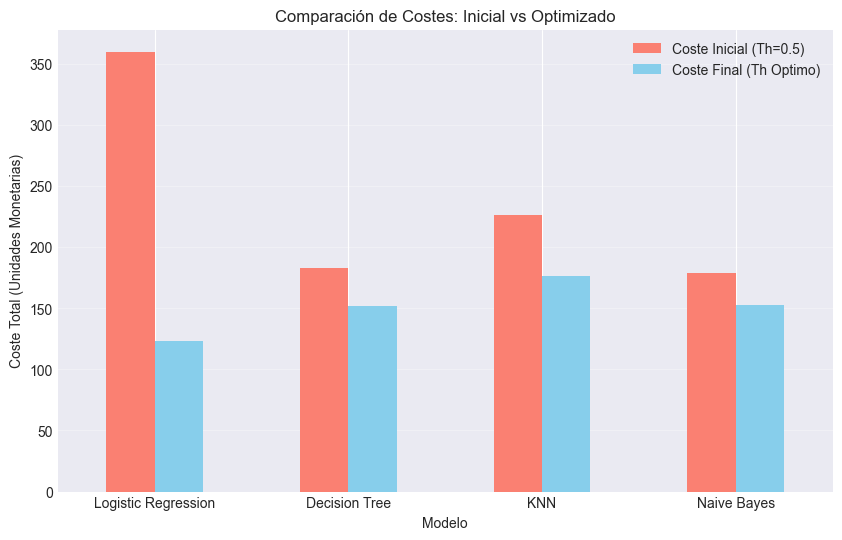


DISCUSIÓN:
El mejor modelo para el negocio es: Logistic Regression con un coste de 123.


In [150]:
# 1. DEFINICIÓN DE LA FUNCIÓN DE COSTE
# Coste = 4 * FP (Prestar a quien no devuelve) + 1 * FN (No prestar a quien devuelve)
# Nota: En sklearn la matriz de confusión es [[TN, FP], [FN, TP]]
# Clase 0: No devuelve (Negativo), Clase 1: Devuelve (Positivo)

def calculate_credit_cost(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    # Aseguramos que la matriz tenga la forma correcta incluso si falta una clase
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        cost = (4 * fp) + (1 * fn)
    else:
        # Fallback por si el modelo predice solo una clase
        cost = 0 
    return cost

# Creamos el scorer para GridSearchCV. 
# 'greater_is_better=False' indica que queremos MINIMIZAR este valor.
cost_scorer = make_scorer(calculate_credit_cost, greater_is_better=False)

# 2. CÁLCULO DEL COSTE DE LOS MODELOS INICIALES
# ------------------------------------------------------------------------------
baseline_costs = {}
print("Costes de los modelos actuales (Umbral 0.5):")
for name, model in models.items():
    y_pred = model.predict(X_test)
    cost = calculate_credit_cost(y_test, y_pred)
    baseline_costs[name] = cost
    print(f" - {name}: {cost}")

# 3. OPTIMIZACIÓN DE PARÁMETROS Y UMBRAL (THRESHOLD)
# ------------------------------------------------------------------------------
# Definimos los espacios de búsqueda para los parámetros
grids = {
    'Logistic Regression': {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
    },
    'Decision Tree': {
        'classifier__max_depth': [3, 5, 7, 10, 15, 20, None],
        'classifier__min_samples_leaf': [1, 5, 10] # Añadimos esto para evitar overfitting
    },
    'KNN': {
        'classifier__n_neighbors': [1, 3, 5, 7, 9, 11, 15]
    }
    # Naive Bayes no tiene hiperparámetros estándar para ajustar en este contexto
}

results_cost = []

# Función auxiliar para encontrar el mejor umbral basado en probabilidades
def optimize_threshold(model, X, y):
    thresholds = np.arange(0.1, 0.95, 0.05)
    costs = []
    y_probs = model.predict_proba(X)[:, 1]
    
    for thresh in thresholds:
        y_pred_thresh = (y_probs >= thresh).astype(int)
        costs.append(calculate_credit_cost(y, y_pred_thresh))
    
    best_idx = np.argmin(costs)
    return thresholds[best_idx], costs[best_idx]

print("\nIniciando optimización (GridSearch + Threshold Tuning)...")

final_models_cost = {} # Guardamos los modelos para el apartado F

for name, pipe in models.items():
    if name == 'Naive Bayes':
        # Naive Bayes no se optimiza por GridSearch aquí, pero sí podemos ajustar el umbral
        best_estimator = pipe
        best_params = "N/A"
        # Coste inicial (sin optimizar umbral)
        y_pred_test = best_estimator.predict(X_test)
        cost_optimized_params = calculate_credit_cost(y_test, y_pred_test)
    else:
        # GridSearch optimizando COSTE (neg_score)
        grid = GridSearchCV(pipe, grids[name], cv=10, scoring=cost_scorer, n_jobs=-1)
        grid.fit(X_train, y_train)
        
        best_estimator = grid.best_estimator_
        best_params = grid.best_params_
        # El score viene negativo por greater_is_better=False
        cost_optimized_params = -grid.score(X_test, y_test) 
    
    # Guardamos modelo optimizado para el futuro
    final_models_cost[name] = best_estimator

    # Optimización del Umbral (Threshold) usando los datos de TRAIN para no fugar información
    best_thresh, _ = optimize_threshold(best_estimator, X_train, y_train)
    
    # Aplicamos ese umbral óptimo al conjunto de TEST
    y_prob_test = best_estimator.predict_proba(X_test)[:, 1]
    y_pred_new_thresh = (y_prob_test >= best_thresh).astype(int)
    cost_final = calculate_credit_cost(y_test, y_pred_new_thresh)
    
    results_cost.append({
        'Modelo': name,
        'Coste Inicial (Th=0.5)': baseline_costs[name],
        'Coste Params Opt (Th=0.5)': cost_optimized_params,
        'Coste Final (Th Optimo)': cost_final,
        'Umbral Óptimo': round(best_thresh, 2),
        'Mejora Total': baseline_costs[name] - cost_final,
        'Params': str(best_params).replace('classifier__', '')
    })

# 4. VISUALIZACIÓN DE RESULTADOS
# ------------------------------------------------------------------------------
df_cost_results = pd.DataFrame(results_cost)
print("\nTABLA COMPARATIVA DE COSTES:")
print(df_cost_results[['Modelo', 'Coste Inicial (Th=0.5)', 'Coste Final (Th Optimo)', 'Umbral Óptimo', 'Mejora Total']].to_string(index=False))

# Gráfico de barras comparativo
df_cost_results.plot(x='Modelo', y=['Coste Inicial (Th=0.5)', 'Coste Final (Th Optimo)'], kind='bar', figsize=(10, 6), color=['salmon', 'skyblue'])
plt.title('Comparación de Costes: Inicial vs Optimizado')
plt.ylabel('Coste Total (Unidades Monetarias)')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

print("\nDISCUSIÓN:")
best_model_row = df_cost_results.loc[df_cost_results['Coste Final (Th Optimo)'].idxmin()]
print(f"El mejor modelo para el negocio es: {best_model_row['Modelo']} con un coste de {best_model_row['Coste Final (Th Optimo)']}.")

El impacto de la función de coste: Al cambiar la métrica de Accuracy a Coste, hemos forzado a los modelos a ser más cautelosos. Un modelo podría tener un Accuracy del 90% pero ser terrible para el negocio si ese 10% de fallos son todos préstamos millonarios impagados (Falsos Positivos). Por lo que no nos interesa acertar lo máximo posible, si no reducir las pérdidas al máximo. 

## Apartado F: Validación Estadística con Bootstrap

In [151]:
# 1. SELECCIÓN AUTOMÁTICA DEL MEJOR MODELO (CRITERIO DE DESEMPATE)
# ------------------------------------------------------------------------------
# Ordenamos por menor coste. En caso de empate, el orden de la lista 'models' 
# (que definimos antes) actúa como desempate implícito.
# Para ser estrictos, priorizamos: LogReg > NaiveBayes > Tree > KNN por simplicidad.

priority_order = ['Logistic Regression', 'Naive Bayes', 'Decision Tree', 'KNN']

# Encontramos el coste mínimo
min_cost = df_cost_results['Coste Final (Th Optimo)'].min()

# Filtramos los modelos que tienen ese coste mínimo (los empatados)
tied_models = df_cost_results[df_cost_results['Coste Final (Th Optimo)'] == min_cost]['Modelo'].tolist()

# Elegimos el ganador basándonos en nuestra prioridad de negocio
best_model_name = next(name for name in priority_order if name in tied_models)
best_model_instance = final_models_cost[best_model_name]
# Recuperamos el umbral óptimo calculado en el apartado anterior
best_thresh_val = df_cost_results.loc[df_cost_results['Modelo'] == best_model_name, 'Umbral Óptimo'].values[0]

print(f"Modelo de Referencia seleccionado (Best Model): {best_model_name}")
print(f"Coste en Test original: {min_cost}")
if len(tied_models) > 1:
    print(f"(Nota: Hubo empate técnico con {tied_models}. Se eligió {best_model_name} por simplicidad/interpretabilidad).")

# 2. EJECUCIÓN DEL BOOTSTRAP
# ------------------------------------------------------------------------------
n_iterations = 1000
alpha = 0.95 # Nivel de confianza
diff_results = {name: [] for name in models.keys() if name != best_model_name}

print(f"\nEjecutando Bootstrap ({n_iterations} iteraciones)... por favor espera.")

# Pre-calculamos predicciones de probabilidad para ir rápido
probs_test = {name: model.predict_proba(X_test)[:, 1] for name, model in final_models_cost.items()}

# Convertimos y_test a array para indexar fácil
y_test_arr = y_test.values

for i in range(n_iterations):
    # Remuestreo con reemplazo de los índices
    indices = resample(np.arange(len(y_test_arr)), replace=True)
    y_sample = y_test_arr[indices]
    
    # Coste del mejor modelo en este sample
    # Usamos el umbral óptimo calculado en el apartado E
    prob_best = probs_test[best_model_name][indices]
    pred_best = (prob_best >= best_thresh_val).astype(int)
    cost_best = calculate_credit_cost(y_sample, pred_best)
    
    # Comparar con el resto
    for name in models.keys():
        if name == best_model_name:
            continue
            
        # Umbral del competidor (buscamos su umbral óptimo en la tabla de resultados)
        thresh_comp = df_cost_results.loc[df_cost_results['Modelo'] == name, 'Umbral Óptimo'].values[0]
        
        prob_comp = probs_test[name][indices]
        pred_comp = (prob_comp >= thresh_comp).astype(int)
        cost_comp = calculate_credit_cost(y_sample, pred_comp)
        
        # Calculamos la diferencia: (Coste Competidor - Coste Mejor)
        # Si es positivo, el Mejor Modelo es realmente mejor (tiene menos coste)
        diff_results[name].append(cost_comp - cost_best)

# 3. ANÁLISIS DE RESULTADOS
# ------------------------------------------------------------------------------
print("\nRESULTADOS DEL TEST DE SIGNIFICANCIA (Intervalo de Confianza 95%):")
print(f"Comparando contra: {best_model_name}")
print("-" * 80)
print(f"{'Modelo Comparado':<25} | {'Media Diff':<10} | {'IC 95% (Inferior, Superior)':<30} | {'¿Significativo?'}")
print("-" * 80)

for name, diffs in diff_results.items():
    lower = np.percentile(diffs, 2.5)
    upper = np.percentile(diffs, 97.5)
    mean_diff = np.mean(diffs)
    
    # Es significativo si el intervalo NO contiene el 0
    # Como calculamos (Otro - Mejor), si todo el intervalo es > 0, el Mejor es significativamente superior.
    is_significant = not (lower <= 0 <= upper)
    sig_str = "SÍ (Peor)" if is_significant and lower > 0 else "NO (Empate)"
    
    print(f"{name:<25} | {mean_diff:<10.2f} | ({lower:<8.2f}, {upper:<8.2f}) {' '*6} | {sig_str}")

print("-" * 80)
print("Nota: Si el intervalo incluye el 0, no hay evidencia estadística para decir que los modelos son diferentes.")

Modelo de Referencia seleccionado (Best Model): Logistic Regression
Coste en Test original: 123

Ejecutando Bootstrap (1000 iteraciones)... por favor espera.

RESULTADOS DEL TEST DE SIGNIFICANCIA (Intervalo de Confianza 95%):
Comparando contra: Logistic Regression
--------------------------------------------------------------------------------
Modelo Comparado          | Media Diff | IC 95% (Inferior, Superior)    | ¿Significativo?
--------------------------------------------------------------------------------
Decision Tree             | 28.31      | (-8.02   , 62.00   )        | NO (Empate)
KNN                       | 52.62      | (11.95   , 91.00   )        | SÍ (Peor)
Naive Bayes               | 28.66      | (-10.00  , 64.02   )        | NO (Empate)
--------------------------------------------------------------------------------
Nota: Si el intervalo incluye el 0, no hay evidencia estadística para decir que los modelos son diferentes.


## Apartado G: Interpretabilidad de Negocio

Calculando Permutation Importance para Logistic Regression...


C:\Users\alvar\AppData\Local\Temp\ipykernel_20284\3007123777.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(result.importances[sorted_idx].T, vert=True, labels=[feature_names[i] for i in sorted_idx])


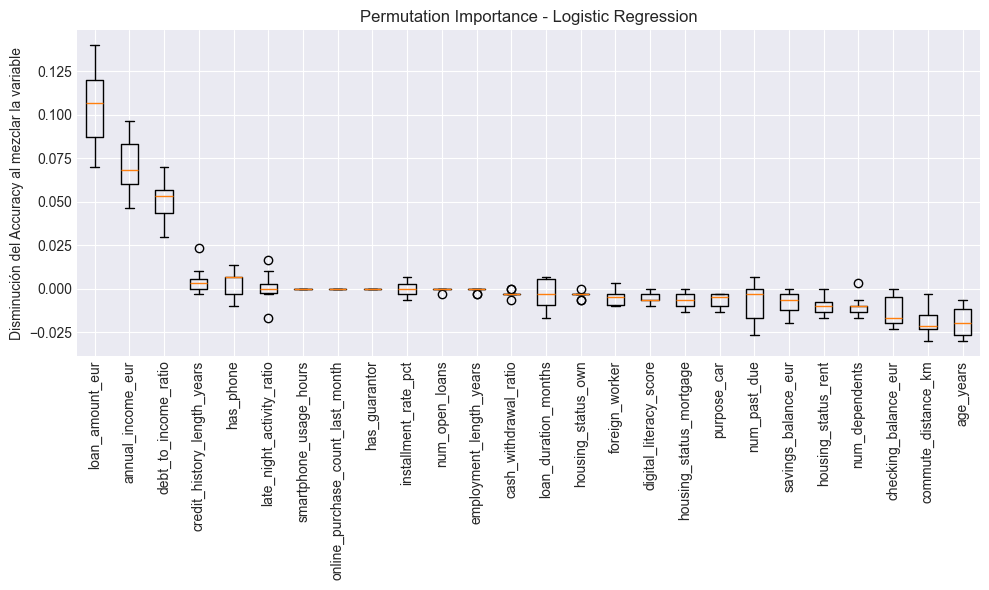


CONCLUSIÓN FINAL DEL PROYECTO:
El modelo seleccionado para implantación es Logistic Regression.
Este modelo minimiza las pérdidas económicas operando con un umbral de corte de 0.7.


In [152]:
def plot_feature_importance(model, model_name, feature_names):
    # Caso 1: Regresión Logística (Coeficientes)
    if 'LogisticRegression' in str(type(model)):
        importances = model.coef_[0]
        # Tomamos valor absoluto para ver la "fuerza" de la variable, sea positiva o negativa
        indices = np.argsort(np.abs(importances))[::-1] 
        plt.figure(figsize=(10, 6))
        plt.title(f"Importancia de Variables (Coeficientes) - {model_name}")
        plt.bar(range(X_train.shape[1]), importances[indices], align="center")
        plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=90)
        plt.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
        plt.ylabel("Peso del Coeficiente (Negativo=Riesgo, Positivo=Solvencia)")
        plt.tight_layout()
        plt.show()
        
        print("INTERPRETACIÓN LOGISTIC REGRESSION:")
        print("- Barras POSITIVAS grandes: Aumentan la probabilidad de devolver el crédito (Buenos clientes).")
        print("- Barras NEGATIVAS grandes: Aumentan el riesgo de impago (Malos clientes).")

    # Caso 2: Árbol de Decisión (Feature Importance)
    elif 'DecisionTreeClassifier' in str(type(model)):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.figure(figsize=(10, 6))
        plt.title(f"Importancia de Variables (Gini) - {model_name}")
        plt.bar(range(X_train.shape[1]), importances[indices], align="center", color='green')
        plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=90)
        plt.ylabel("Importancia Relativa")
        plt.tight_layout()
        plt.show()
        
        print("INTERPRETACIÓN ARBOL DE DECISIÓN:")
        print("- Estas son las variables que el árbol usa más frecuentemente para dividir a los clientes.")
        print("- Las primeras variables son las más críticas para determinar el riesgo.")

    # Caso 3: Otros (KNN/NaiveBayes) - Usamos Permutation Importance (método agnóstico)
    else:
        from sklearn.inspection import permutation_importance
        print(f"Calculando Permutation Importance para {model_name}...")
        result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
        sorted_idx = result.importances_mean.argsort()[::-1]
        
        plt.figure(figsize=(10, 6))
        plt.boxplot(result.importances[sorted_idx].T, vert=True, labels=[feature_names[i] for i in sorted_idx])
        plt.title(f"Permutation Importance - {model_name}")
        plt.xticks(rotation=90)
        plt.ylabel("Disminución del Accuracy al mezclar la variable")
        plt.tight_layout()
        plt.show()

# Obtenemos los nombres de las columnas después del OneHotEncoding
# (Necesitamos acceder al paso 'preprocessor' del pipeline original o reconstruirlo mentalmente)
# Truco para sacar los nombres del ColumnTransformer:
try:
    ohe_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    all_feature_names = numeric_features + list(ohe_cols)
except:
    # Fallback si la versión de scikit-learn es antigua o da error
    all_feature_names = [f"Var_{i}" for i in range(X_train.shape[1])]

# Ejecutamos la interpretación sobre el MEJOR MODELO elegido en el apartado F
plot_feature_importance(best_model_instance, best_model_name, all_feature_names)

print("\nCONCLUSIÓN FINAL DEL PROYECTO:")
print(f"El modelo seleccionado para implantación es {best_model_name}.")
print(f"Este modelo minimiza las pérdidas económicas operando con un umbral de corte de {best_thresh_val}.")